# Windows-based Stereo

In [1]:
%matplotlib inline

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from skimage import img_as_ubyte
from skimage.color import rgb2grey

#### $\text{rds_left.gif}$ and $\text{rds_right.gif}$: random dot stereo pair

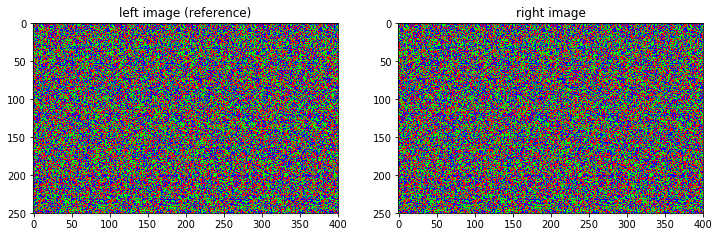

In [57]:
im_left = image.imread("images/stereo_pairs/rds_left.gif")
im_right = image.imread("images/stereo_pairs/rds_right.gif")

fig = plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(122)
plt.title("right image")
plt.imshow(im_right)

# the range of disparities for this random dot stereo pair 
d_min = 0
d_max = 2

#### Compute and visualize an array of "squared differences" between RGB pixel values in the left and the right images. Each RGB pixel value is a 3-vector, and the "squared difference" is defined as squared L2 norm of the difference between the corresponding vectors. 

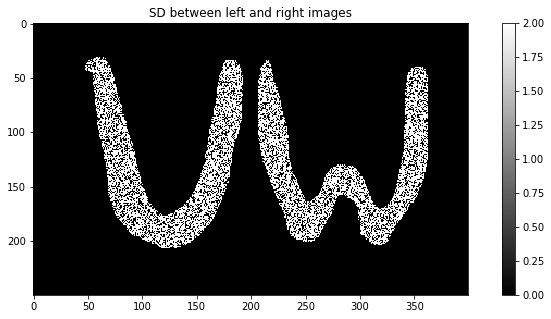

In [58]:
SD = np.zeros(np.shape(im_left))
SD = (im_left / 255 - im_right / 255) ** 2 # convert R, G, B values to floats
SD = np.sum(SD, axis=2)
fig = plt.figure(figsize = (12, 5))
plt.title("SD between left and right images")
plt.imshow(SD, cmap = "gray")
plt.colorbar()

#### The function $\text{SD_array()}$ computes squared differences between RGB pixel values in the reference (left) image and the "shifted" right image for ALL shifts/disparities $\Delta$ in the range $\Delta\in [d_{minimum},d_{maximum}]$. The output should be array $SD$ such that $SD[d]$ is an image of Squared Differences for given shift $d$. 

In [59]:
def SD_array(imageL, imageR, d_minimum, d_maximum):
    # initialization of the array of "squared differences" for different shifts
    SD = np.zeros((1+d_maximum-d_minimum,np.shape(imageL)[0],np.shape(imageL)[1]))
    for i in range(1+d_maximum-d_minimum):
        padding = np.zeros((imageL.shape[0], d_minimum + i, np.shape(imageL)[2]))
        imageR_shifted = np.hstack((padding, imageR[:,:-(d_minimum + i),:])) if d_minimum + i > 0 else imageR
        SD[i] = np.sum((imageL / 255 - imageR_shifted / 255) ** 2, axis=2)
    return SD

#### Apply $\text{SD_array()}$ function to compute SD images for the random dot stereo pair. Visualize such squared difference images for $\Delta=d_{min}$, $\Delta = d_{mid}\approx\frac{d_{min}+d_{max}}{2}$, and $\Delta=d_{max}$.

(250, 400, 4)
(250, 400, 4)
(3, 250, 400)


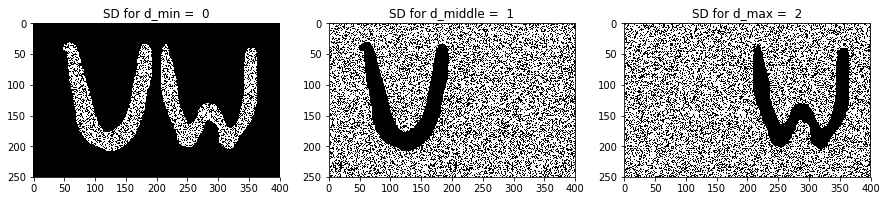

In [60]:
SD = SD_array(im_left, im_right, d_min, d_max)    
print(np.shape(im_left))
print(np.shape(im_right))
print(np.shape(SD))

fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.25, 0.01, 0.5]))

#### Function $\text{integral_image()}$ computes an "integral image" for any given "scalar" image

In [90]:
# Function integral_image can be applied to any scalar 2D array/image. 
# This function should return a double/float64 (precision) array/image of the same size.
# NOTE: it is safer to explicitly specify double/float64 precision for integral images since 
# later there will be adding/subtracting ("differenting") of their values in nearby pixels.

def integral_image(img):
    img_line_integral = img.copy()
    for i in range(img.shape[1]-1):
        shifted_img = np.roll(img, i + 1,  axis=1)
        shifted_img[:, :i + 1] = 0
        img_line_integral += shifted_img

    img_integral = img_line_integral.copy()
    for i in range(img.shape[0]-1):
        shifted_img_line_integral = np.roll(img_line_integral, i + 1, axis=0)
        shifted_img_line_integral[:i + 1, :] = 0
        img_integral += shifted_img_line_integral
    return img_integral.astype(np.float64)

#### Apply $\text{intergal_image()}$ function to the "squared differences" (SD) for each disparity.

(3, 250, 400) (3, 250, 400)


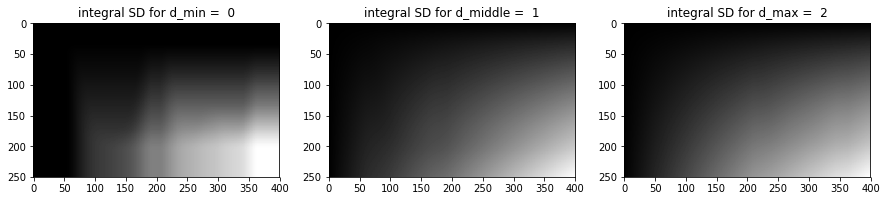

In [91]:
integral_SD = np.zeros(np.shape(SD))
print(np.shape(integral_SD),np.shape(SD))

for Delta in range(1+d_max-d_min):
    integral_SD[Delta] = integral_image(SD[Delta])

fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('integral SD for d_min = {:>2d}'.format(d_min))
plt.imshow(integral_SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('integral SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(integral_SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('integral SD for d_max = {:>2d}'.format(d_max))
plt.imshow(integral_SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

#### Function $\text{windSum()}$ sums the elements of the input image within fixed-size windows around image pixels. This function works for any (odd or even) values of parameter $\text{window_width}\in\{1,2,3,4,5,...\}$ according to the windows illustration below: <img src="images\windows.png">

In [92]:
# function windSum can be applied to any scalar 2D array/image. It should return an array/image where the value of 
# each element (pixel p) is the "sum" of the values in the input array/image within a window around element p.
# The return image should be of the same size/type and have its margins (around half-window width) filled with INFTY.
from math import floor, ceil
INFTY = np.inf

def windSum(img, window_width):
    img_sum = np.zeros((img.shape[0] + 1, img.shape[1] + 1))
    left_padding = np.zeros((img.shape[0], 1))
    top_padding = np.zeros(img.shape[1] + 1)
    img_integral = np.vstack((top_padding, np.hstack((left_padding, integral_image(img)))))
    f = floor(window_width / 2)
    c = ceil(window_width / 2)
    
    top_left = np.roll(img_integral, (c, c), axis=(0, 1))
    top_right = np.roll(img_integral, (c, -f), axis=(0, 1))
    bottom_left = np.roll(img_integral, (-f, c), axis=(0, 1))
    bottom_right = np.roll(img_integral, (-f, -f), axis=(0, 1))
    img_sum = (bottom_right + top_left - top_right - bottom_left)[1:,1:]

    top_left_margin = c - 1
    bottom_right_margin = f
    if top_left_margin > 0: 
        img_sum[:top_left_margin] = INFTY
        img_sum[:,:top_left_margin] = INFTY
    if bottom_right_margin > 0:
        img_sum[-bottom_right_margin:] = INFTY
        img_sum[:,-bottom_right_margin:] = INFTY
    return img_sum

#### Compute SSD images for windows of different widths and for different disparities by applying $\text{windSum}$ function to the "squared differences" SD.

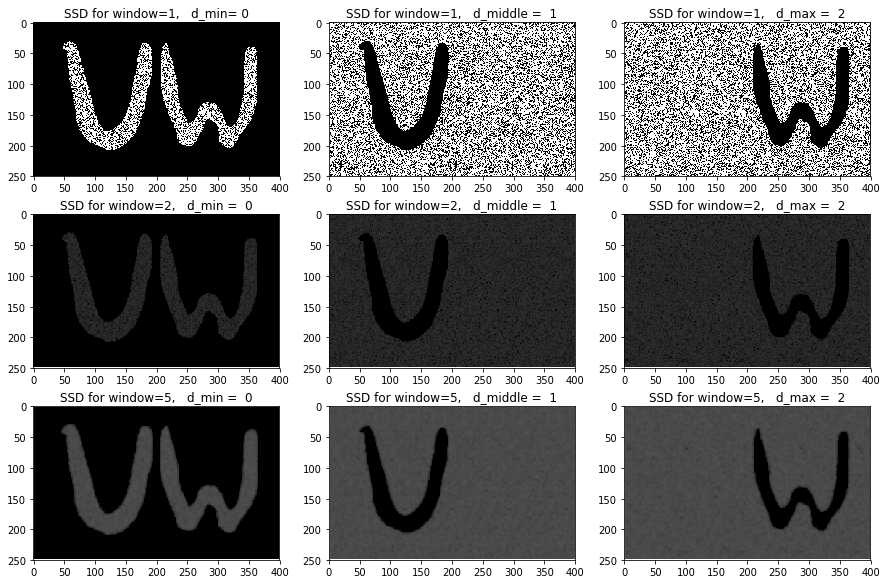

In [93]:
SSD1 = np.zeros(np.shape(SD))
SSD2 = np.zeros(np.shape(SD))
SSD5 = np.zeros(np.shape(SD))

for Delta in range(1+d_max-d_min):
    SSD1[Delta] = windSum(SD[Delta],1)
    SSD2[Delta] = windSum(SD[Delta],2)
    SSD5[Delta] = windSum(SD[Delta],5)
    
d_middle = round((d_min+d_max)/2)
        
fig = plt.figure(figsize = (15, 10))
plt.subplot(331)
plt.title('SSD for window=1,   d_min={:>2d}'.format(d_min))
plt.imshow(1+SSD1[0], cmap = "gray")
plt.subplot(332) 
plt.title('SSD for window=1,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD1[d_middle-d_min], cmap = "gray")
plt.subplot(333)
plt.title('SSD for window=1,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD1[d_max-d_min], cmap = "gray")
plt.subplot(334)
plt.title('SSD for window=2,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD2[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(335) 
plt.title('SSD for window=2,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD2[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(336)
plt.title('SSD for window=2,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD2[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(337)
plt.title('SSD for window=5,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD5[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(338) 
plt.title('SSD for window=5,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD5[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(339)
plt.title('SSD for window=5,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD5[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))

#### Function $\text{SSDtoDmap()}$ computes "disparity map" from SSD arrays (as above) for each disparity in the range specified by integers $d_{min}$, $d_{max}$. It should return a disparity map (image). At each pixel, disparity map has disparity value corresponding to the minimum SSD at this pixel. For pixels at the margins, the disparity map is set to zero. Note: margin pixels are characterized by $INFTY$ values of $SSD$.

In [94]:
def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    dMap = np.full(np.shape(SD[0]),d_minimum)
    dMin_prev = SSD_array[0]
    for i in range(1, d_maximum - d_minimum + 1):
        dMin = np.minimum(dMin_prev, SSD_array[i])
        dMap = np.where(dMin == dMin_prev, dMap, i + d_minimum)
        dMin_prev = dMin
    dMap = np.where(SSD_array[0] != INFTY, dMap, 0)
    return dMap

### Compute and show disparity map 

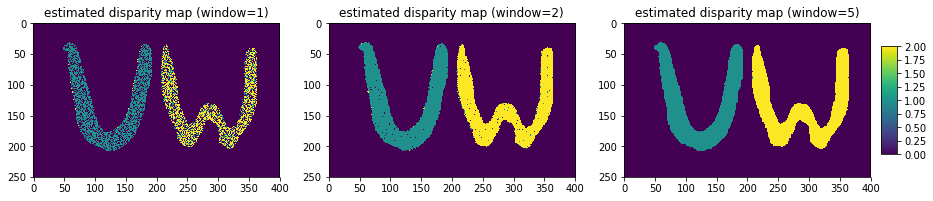

In [95]:
dMap1 = SSDtoDmap(SSD1,d_min,d_max)
dMap2 = SSDtoDmap(SSD2,d_min,d_max)
dMap5 = SSDtoDmap(SSD5,d_min,d_max)

fig = plt.figure(figsize = (15, 3))
plt.subplot(131)
plt.title("estimated disparity map (window=1)")
plt.imshow(dMap1, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("estimated disparity map (window=2)")
plt.imshow(dMap2, vmin = 0, vmax = d_max)
plt.subplot(133)
plt.title("estimated disparity map (window=5)")
plt.imshow(dMap5, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.25, 0.015, 0.5]))

#### Test on a real stereo pair with ground truth (Tsukuba). The full Tsukuba dataset and other stereo images with ground-truth disparity maps: http://vision.middlebury.edu/stereo/

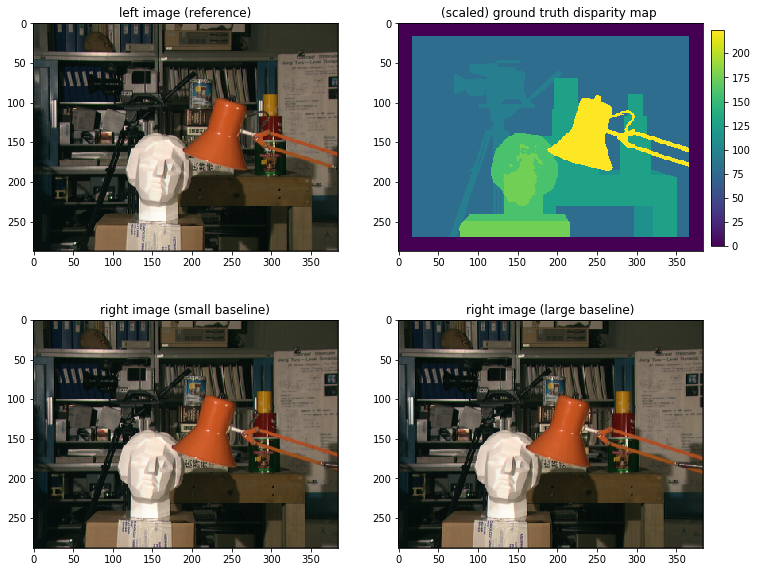

In [96]:
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")
im_right2 = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col5.ppm")

fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("(scaled) ground truth disparity map ")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(223)
plt.title("right image (small baseline)")
plt.imshow(im_right)
plt.subplot(224)
plt.title("right image (large baseline)")
plt.imshow(im_right2)

#### Note that the integer-valued ground truth image above represents scaled disparity values for the pixels in the reference (left) mage. The scale w.r.t. the small baseline right image ($\text{im_right}$) is 16.

#### Estimate the range of disparity values between pixels in the left image ($\text{im_left}$) and the right image ($\text{im_right}$) using ground truth disparity map.

In [97]:
u = np.unique(im_gt/16)
d_min = int(u[1])
d_max = int(u[-1])

### Compute squared differences using $\text{SD_array}$ function and visualize the results using logarithmic scale. Note: linear scale would make it hard to see smaller squared differences since there are many very large ones.

<class 'int'>


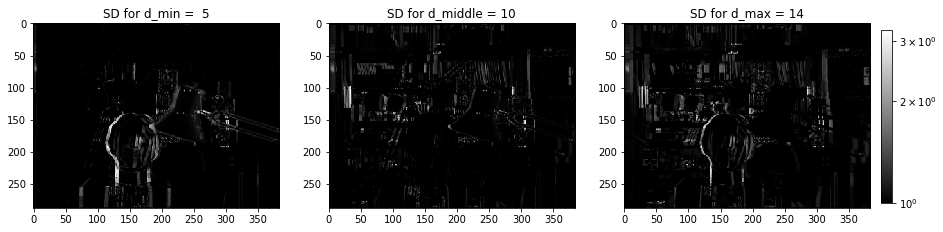

In [98]:
SD = SD_array(im_left, im_right, d_min, d_max) 
# print(np.unique(SD[0], return_counts=True))
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(im_left)
plt.imshow(1+SD[0], cmap = "gray", norm=LogNorm())
plt.subplot(132) 
d_middle = round((d_min + d_max)/2)
print(type(d_min))
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SD[d_middle-d_min], cmap = "gray", norm=LogNorm())
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(1+SD[d_max-d_min], cmap = "gray", norm=LogNorm())
plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

### Observations:

(1) When the disparity is set to its minimum, most of the background (e.g. bookshelf) is black out, which implies that the backgroud has the lowest disparity which is 5.

(2) When the disparity is set to its medium, the middle-ground (e.g. plaster statue) is black out, which implies that the middle-ground has its disparity level around 10.

(3) When the disparity is set to its maximum, the foreground (e.g. lamp) is black out, which implies that the foreground has the highest diparity which is 14.

#### Function $\text{Dmap_Windows()}$ returns disparith map from a given stereo pair (left and right image), specified disparity range, and window size.

In [99]:
def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    SSD = np.zeros(np.shape(SD))
    for Delta in range(1+d_maximum-d_minimum):
        SSD[Delta] = windSum(SD[Delta], window_width)
    dMap = SSDtoDmap(SSD,d_minimum,d_maximum)
    return dMap

#### Compute and show disparity maps for Tsukuba using small and large windows.

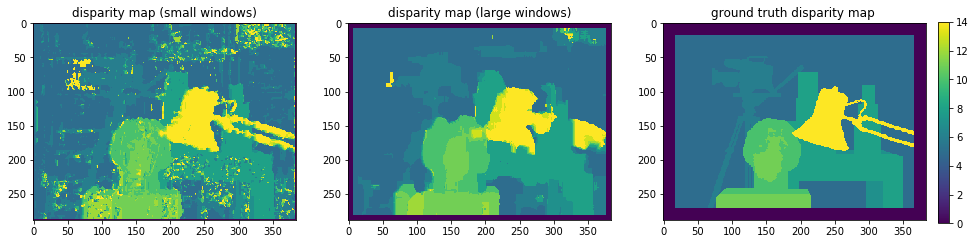

In [100]:
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))